In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import time
import scipy.linalg as scilinalg
import seaborn as sns
from scipy.stats import ortho_group
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import multiprocessing as mp
from joblib import Parallel, delayed
import sys
sys.path.append('..')
from utils import *
from conf_simu import *

np.random.seed(1234)

In [6]:
# plot hist
d1 = d2 = 500
alpha = 0.1
sd0 = 1
tail = 'gaussian'
het = 'homo' # 'homo' | 'logis' | 'rank1'
pr = 0.8
sigma_true=False
m = 500   #number of unobserved entries for evaluation
m_mean = 2
kap = 1


# model specification
k_star = 8
# working rank
rk = 8

mis_set = 0
if mis_set==2:
    M_mean = 0.2
    sd = sd0
else:
    M_mean = m_mean
    sd = sd0
if mis_set==3:
    tail='t'
    sd = 0.2
else:
    tail='gaussian'
    sd = sd0
                        
M_star, A, P = gen_(d1,d2,het,sd,tail,pr,M_mean,mis_set,k_star)
S = (A!=0)

# empirical quantiles
a = A.ravel()
a = a[a!=0]
lo_q = np.quantile(a, alpha/2)
up_q = np.quantile(a, 1-alpha/2)

# M_star: underlying true matrix
# A: partially observed matrix

# unobserved indices
ind_test_all = np.transpose(np.nonzero(S==0))
n0 = ind_test_all.shape[0]
ind_test = ind_test_all

# construct lower & upper bnds
base1 = 'cvx'
base2 = 'als'    # base algorithm
lo_hat, up_hat, r, qvals, _, _ = cmc(A,ind_test,alpha,P,rk,wtd=True,het=het,w=[],oracle=False,base=base2,kap=kap)

# model-based methods
p_est = np.mean(S)
u, s, vh = svds_(A/p_est, rk)
M_spectral = u@np.diag(s)@vh
sigma_est_spec = np.sqrt(np.sum(((A-M_spectral)*S)**2)/(d1*d2*p_est))


# alternative least squares
penalty = 0.0
Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
itn = 0
while (np.linalg.norm(Mhat_als-M_star) / np.linalg.norm(M_star) > 1) and (itn <= 5):
    Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
    itn += 1

s_als = np.sqrt(sigmaS_als**2 + sigma_est_als**2)

mul = norm.ppf(1-alpha/2)
lo_uq_mat = Mhat_als - s_als * mul
up_uq_mat = Mhat_als + s_als * mul
lo_uq_als = lo_uq_mat[S==0].reshape(-1)
up_uq_als = up_uq_mat[S==0].reshape(-1)



# convex
eta = 1
Mhat_cvx, X_d_cvx, Y_d_cvx, sigma_est_cvx, sigmaS_cvx = cvx_mc(A, S, p_est, rk, sigma_est_spec, eta=eta)

s_cvx = np.sqrt(sigmaS_cvx**2 + sigma_est_cvx**2)

lo_uq_mat = Mhat_cvx - s_cvx * mul
up_uq_mat = Mhat_cvx + s_cvx * mul
lo_uq_cvx = lo_uq_mat[S==0].reshape(-1)
up_uq_cvx = up_uq_mat[S==0].reshape(-1)

# evaluation
m_star = []
for i in range(ind_test.shape[0]):
    m_star = np.append(m_star, M_star[ind_test[i,0],ind_test[i,1]])
label1 = 'cmc-'+base1
label2 = 'cmc-'+base2
label3 = 'cvx'
label4 = 'als'
# compute coverage rate and average length
cov_rt_hat = np.mean((lo_hat <= m_star) & (up_hat >= m_star))
cov_rt_uq_cvx = np.mean((lo_uq_cvx <= m_star) & (up_uq_cvx >= m_star))
cov_rt_uq_als = np.mean((lo_uq_als <= m_star) & (up_uq_als >= m_star))
cov_rt_q = np.mean((lo_q <= m_star) & (up_q >= m_star))
len_ave_hat = np.round(np.mean((up_hat - lo_hat)),4)
len_ave_uq_cvx = np.round(np.mean((up_uq_cvx - lo_uq_cvx)),4)
len_ave_uq_als = np.round(np.mean((up_uq_als - lo_uq_als)),4)
len_ave_q = np.round(np.mean((up_q - lo_q)),4)

u_hat_cvx = np.divide((Mhat_cvx - M_star)[S==0],s_cvx[S==0]).reshape(-1)
u = np.random.normal(0,1,10000)
u_hat_als = np.divide((Mhat_als - M_star)[S==0], s_als[S==0]).reshape(-1)

print([cov_rt_hat, cov_rt_uq_cvx, cov_rt_uq_als, cov_rt_q])
print([len_ave_hat, len_ave_uq_cvx, len_ave_uq_als, len_ave_q])


[0.8989958057751251, 0.8916357477012421, 0.8917970640425875, 0.8991571221164704]
[3.38, 3.2898, 3.2874, 9.0309]


[0.8989958057751251, 0.8916357477012421, 0.8917970640425875]


<Figure size 640x480 with 0 Axes>

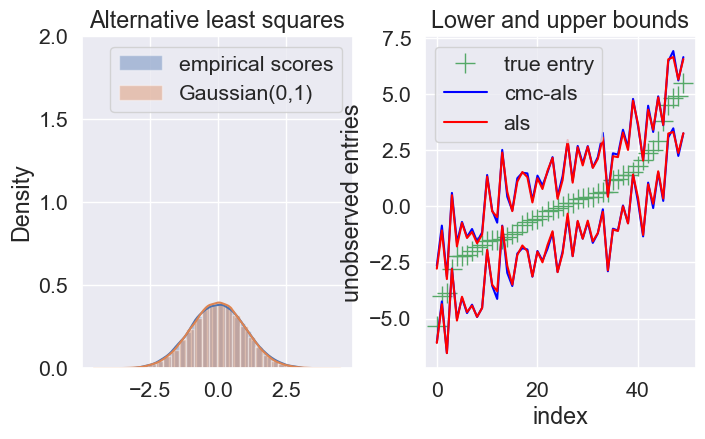

In [7]:
u_hat_cvx = np.divide((Mhat_cvx - M_star)[S==0],s_cvx[S==0]).reshape(-1)
u = np.random.normal(0,1,10000)
u_hat_als = np.divide((Mhat_als - M_star)[S==0], s_als[S==0]).reshape(-1)

print([cov_rt_hat, cov_rt_uq_cvx, cov_rt_uq_als])
# plot
fig = plt.figure()
fig, ax = plt.subplots(ncols=2,figsize=(7,4))
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)

ind = np.random.choice(n0,50)
ind_seq = range(50)

u = np.random.normal(0,1,100000)
sns.distplot(u_hat_als[np.abs(u_hat_als)<3], bins=30,kde=True, hist=True,label='empirical scores',ax=ax[0])
sns.distplot(u, bins=30,kde=True, hist=True,label='Gaussian(0,1)',ax=ax[0])
ax[0].legend(loc='best')
ax[0].set_title('Alternative least squares')
ax[0].set_ylim((0,2))

m_ = m_star[ind]
sort_ord = m_.argsort()
ind = ind[sort_ord]
ax[1].plot(ind_seq,m_star[ind],'g+',label='true entry',markersize=15)
ax[1].plot(ind_seq,lo_hat[ind],label=label2,c='blue')
ax[1].plot(ind_seq,up_hat[ind],c='blue')
ax[1].plot(ind_seq,lo_uq_als[ind],label=label4,c='red')
ax[1].plot(ind_seq,up_uq_als[ind],c='red')
ax[1].legend(loc='best')
ax[1].set_xlabel('index')
ax[1].set_ylabel('unobserved entries')
ax[1].set_title('Lower and upper bounds')

plt.savefig('../plots/robust_plot_'+str(alpha)+'_'+str(d1)+'_'+str(mis_set)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(rk)+'.pdf', bbox_inches='tight')
